In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from datetime import datetime
import numpy as np
import random


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

!pip install miceforest
import miceforest as mf


In [17]:
# path = "/Users/dbabichenko/OneDrive - University of Pittsburgh/Research/IBD Research/Inflammatory Bowel Disease DOD Grant/data/Merged Data 2021"
path = "/Users/dmitriyb/OneDrive - University of Pittsburgh/Research/IBD Research/Inflammatory Bowel Disease DOD Grant/data/Merged Data 2021"

In [18]:
patients = pd.read_csv(path + '/patients_merged.csv')
patients['GENDER'] = patients['GENDER'].map({'M' : 0, 'F': 1, 'FEMALE' : 1, 'MALE' : 0})
patients['AGE'] = datetime.today().year - patients['BIRTH_YEAR']

# “married”, “single”, and “unknown”.
m_status = {
    'Married' : 'married',
    'Single' : 'single',
    'Divorced' : 'single',
    'Widowed' :  'single',
    'Legally Separated' : 'single',
    'Committed relationship' : 'married',
    'Significant other' : 'married'
}

patients['MARITAL STATUS'] = patients['MARITAL STATUS'].map(m_status)
patients['MARITAL STATUS'].fillna('unknown', inplace=True)

# “employed”, “not employed”, “student”, “unknown”
emp_status = {
    'Full Time' : 'employed', 
    'Not Employed' : 'not employed', 
    'Student - Full Time' : 'student',
    'Part Time' : 'employed', 
    'Retired' : 'not employed', 
    'Self Employed' : 'employed', 
    'Student - Part Time' : 'student'
}
patients['EMPLOYMENT_STATUS'] = patients['EMPLOYMENT_STATUS'].map(emp_status)
patients['EMPLOYMENT_STATUS'].fillna('unknown', inplace=True)



patients.drop(['Unnamed: 0', 'DATA_SOURCE', 'IS_ALIVE', 'BIRTH_YEAR', 'RACE', 'ETHNIC_GROUP'], axis=1, inplace=True)

In [19]:
patients.head()

,GENDER,MARITAL STATUS,EMPLOYMENT_STATUS,PROJECT_PATIENT_ID,AGE
0,0,unknown,unknown,64a0ac31-091d-45c5-86e3-86516ee4299a,63
1,1,unknown,unknown,7da2e9db-ae3b-41bc-a467-fa2d9afe25ea,93
2,1,unknown,unknown,524c0db3-6ef0-47c6-9b99-098d0bf998cd,63
3,1,unknown,unknown,ed3a3f1a-0c26-402b-b922-159589036b46,67
4,0,unknown,unknown,4d3ea8f4-15b6-477f-805e-7932c6aabc74,33


In [20]:
patients.describe()

,GENDER,AGE
count,6235.000000,6235.000000
mean,0.547875,53.112911
std,0.497743,17.939408
min,0.000000,19.000000
25%,0.000000,38.000000
50%,1.000000,52.000000
75%,1.000000,67.000000
max,1.000000,105.000000


In [21]:
patients.dtypes

GENDER                 int64
MARITAL STATUS        object
EMPLOYMENT_STATUS     object
PROJECT_PATIENT_ID    object
AGE                    int64
dtype: object

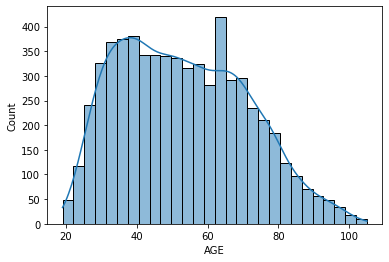

In [22]:
sns.histplot(patients.AGE, kde=True)
plt.show()

<AxesSubplot:>

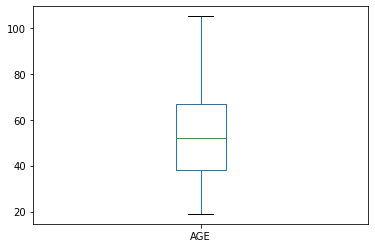

In [29]:
patients['AGE'].plot.box()

## Encounters

In [23]:
# The number of office visits
# The number of outpatient procedures
# The number of telephone + email encounters

encounters = pd.read_csv(path + '/encounters_merged.csv')
encounters.drop(['Unnamed: 0','ENCOUNTER_DATE','DEPT_NAME','ICD9_CODE','ICD10_CODE','PRIMARY_DX'], axis=1, inplace=True)
q = "ENCOUNTER_TYPE == 'TELEPHONE'"
q += " or ENCOUNTER_TYPE == 'OFFICE VISIT'"
q += " or ENCOUNTER_TYPE == 'APPOINTMENT'"
q += " or ENCOUNTER_TYPE == 'PATIENT EMAIL'"
q += " or ENCOUNTER_TYPE == 'NEW PATIENT VISIT'"
q += " or ENCOUNTER_TYPE == 'PROCEDURE VISIT'"
q += " or ENCOUNTER_TYPE == 'TESTING VISIT'"


encounters = encounters.query(q)

enc_map = {
    'TELEPHONE' : 'phone',
    'OFFICE VISIT' : 'visit', 
    'APPOINTMENT' : 'visit',
    'PATIENT EMAIL' : 'phone',
    'NEW PATIENT VISIT' : 'visit',
    'PROCEDURE VISIT' : 'outpatient', 
    'TESTING VISIT' : 'outpatient'
}

encounters['ENCOUNTER_TYPE'] = encounters['ENCOUNTER_TYPE'].map(enc_map)

temp = encounters.groupby(['PROJECT_PATIENT_ID','ENCOUNTER_TYPE']).agg({'ENCOUNTER_TYPE': 'count'})
temp.columns = ['COUNTS']
temp.reset_index(inplace=True)
temp.head()
table = pd.pivot_table(temp, values='COUNTS', index=['PROJECT_PATIENT_ID'],
                    columns=['ENCOUNTER_TYPE'])
table.columns = table.columns.get_level_values(0)
table.columns = [''.join(col).strip() for col in table.columns.values]
table.reset_index(inplace=True)
table.fillna(0, inplace=True)
encounters = table

# The number of emergency department (ED) visits
# The number of hospitalizations.
hosp = pd.read_csv(path + '/hospitalizations_and_er_visits_merged.csv')
hosp.drop(['Unnamed: 0', 'CONTACT_DATE'], axis=1, inplace=True)

temp = hosp.groupby('PROJECT_PATIENT_ID').agg({'IS_HOSPITALIZATION' : 'sum', 'IS_ER_VISIT' : 'sum'})
temp.reset_index(inplace=True)
encounters = pd.merge(encounters, temp, how='outer', on = 'PROJECT_PATIENT_ID')
encounters.fillna(0, inplace=True)
encounters.columns = ['PROJECT_PATIENT_ID', 'OUTPATIENT', 'PHONE', 'VISIT', 'HOSPITALIZATION', 'ER']
encounters.head()


,PROJECT_PATIENT_ID,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER
0,000b3bdc-50c8-490b-acd0-64754abb91df,0.0,0.0,1.0,0.0,0.0
1,001ebb31-0d52-4814-8f19-39d88bee3b29,0.0,23.0,7.0,0.0,10.0
2,002feddb-9223-4c1e-b56c-9bcee72592a3,0.0,1.0,0.0,0.0,1.0
3,004977aa-bdab-4a53-a820-d053281b93b0,0.0,2.0,1.0,2.0,5.0
4,004bdaf8-b671-4b79-a0e4-44dab472560f,0.0,21.0,5.0,1.0,0.0


In [24]:
encounters.describe()

,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER
count,5621.000000,5621.000000,5621.00000,5621.000000,5621.000000
mean,0.014944,16.055328,6.20797,3.149084,5.096958
std,0.170171,25.972069,7.97670,6.446427,11.572702
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,7.000000,4.00000,1.000000,2.000000
75%,0.000000,22.000000,9.00000,3.000000,5.000000
max,8.000000,356.000000,104.00000,87.000000,195.000000


In [25]:
encounters.dtypes

PROJECT_PATIENT_ID     object
OUTPATIENT            float64
PHONE                 float64
VISIT                 float64
HOSPITALIZATION       float64
ER                    float64
dtype: object

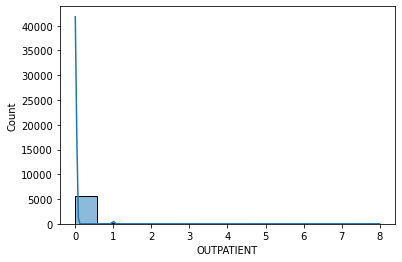

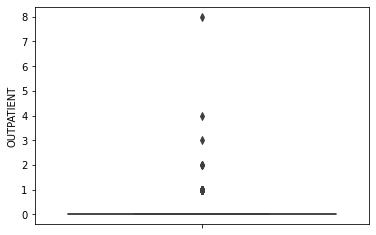

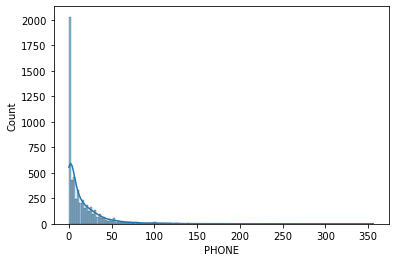

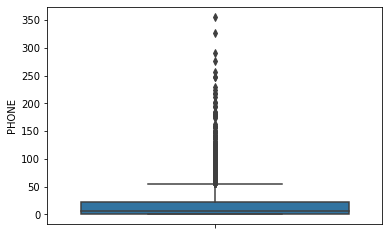

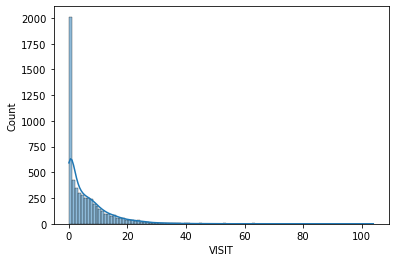

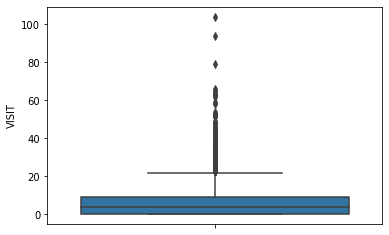

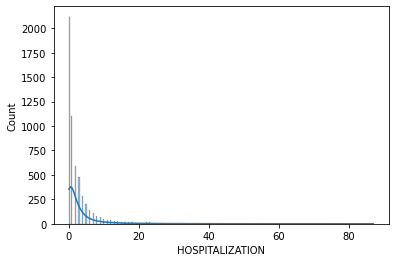

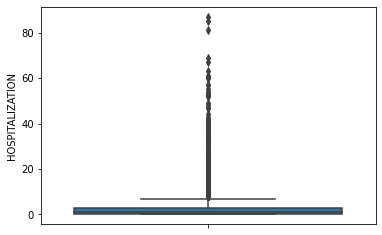

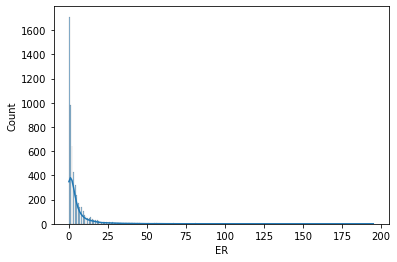

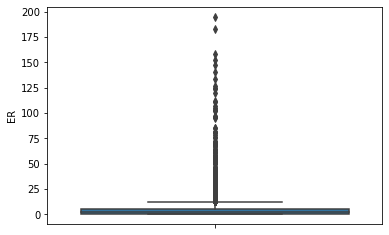

In [32]:
for col in ['OUTPATIENT', 'PHONE', 'VISIT', 'HOSPITALIZATION', 'ER']:
    sns.histplot(encounters[col], kde=True)
    plt.show()
    sns.boxplot( y=encounters[col] );
    plt.show()

## Labs



In [33]:
labs = pd.read_csv(path + '/labs_merged.csv')
labs.head()

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,RESULT_DATE,ORDER_PROC_ID,COMPONENT_NAME,ORD_VALUE,ORD_NUM_VALUE,REFERENCE_UNIT,REFERENCE_LOW,REFERENCE_HIGH,RESULT_FLAG,GROUP,PROJECT_PATIENT_ID
0,0,03/27/2015,203602100,SPECIMEN DESCRIPTION,Stool,NaN,NaN,NaN,NaN,NaN,NaN,524c0db3-6ef0-47c6-9b99-098d0bf998cd
1,1,03/27/2015,203602100,SPECIAL REQUESTS,None,NaN,NaN,NaN,NaN,NaN,NaN,524c0db3-6ef0-47c6-9b99-098d0bf998cd
2,2,03/27/2015,203602100,CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524c0db3-6ef0-47c6-9b99-098d0bf998cd
3,3,03/27/2015,203602100,REPORT,Final Result 03/27/2015,NaN,NaN,NaN,NaN,NaN,NaN,524c0db3-6ef0-47c6-9b99-098d0bf998cd
4,4,03/23/2015,114670251,LIPASE,164,164.0,U/L,50,393,NaN,NaN,524c0db3-6ef0-47c6-9b99-098d0bf998cd


In [34]:
# eosinophils (EOS)
# monocytes 
# albumin
# hemoglobin 
# erythrocyte sedimentation rate (ESR)
# c-reactive Protein (CRP)
# vitamin D 

In [35]:
q = "GROUP == 'monocytes'"
q += " or GROUP == 'eos'"
q += " or GROUP == 'hemoglobin'"
q += " or GROUP == 'albumin'"
q += " or GROUP == 'crp'"
q += " or GROUP == 'esr'"
q += " or GROUP == 'vitamin_d'"
labs = labs.query(q)

temp = labs.groupby(['PROJECT_PATIENT_ID','GROUP']).agg({
    'ORD_NUM_VALUE' : ['mean']
})

temp.reset_index(inplace=True)
temp.columns = ['PROJECT_PATIENT_ID', 'LAB', 'RESULT']
temp.head()

table = pd.pivot_table(temp, values=['RESULT'], index=['PROJECT_PATIENT_ID'],
                    columns=['LAB'])

table.reset_index(inplace=True)
table.columns = ['PROJECT_PATIENT_ID','ALBUMIN','CRP','EOS','ESR','HEMOGLOBIN','MONOCYTES','VITAMIN_D']
table.head()
labs = table


In [36]:
labs.describe()

,ALBUMIN,CRP,EOS,ESR,HEMOGLOBIN,MONOCYTES,VITAMIN_D
count,3.605000e+03,2.995000e+03,3.635000e+03,3.016000e+03,3.653000e+03,3.638000e+03,2.814000e+03
mean,4.956560e+03,1.169671e+06,1.824910e+04,2.366458e+04,1.021568e+04,1.811372e+04,1.486897e+04
std,6.826875e+04,2.394740e+06,1.262835e+05,3.393634e+05,1.147238e+05,1.180229e+05,2.446051e+05
min,1.271429e+00,2.000000e-02,0.000000e+00,0.000000e+00,6.900000e+00,5.000000e-01,4.000000e+00
25%,3.666667e+00,5.244032e-01,1.002314e+00,1.000000e+01,1.209000e+01,4.071250e+00,2.700000e+01
50%,4.000000e+00,2.500000e+00,2.271429e+00,1.712500e+01,1.321207e+01,6.175000e+00,3.433333e+01
75%,4.300000e+00,1.250000e+06,1.829321e+01,2.992083e+01,1.431250e+01,6.885106e+01,4.225000e+01
max,2.500003e+06,9.999999e+06,3.333389e+06,9.999999e+06,5.000006e+06,2.500061e+06,9.999999e+06


In [37]:
labs.dtypes

PROJECT_PATIENT_ID     object
ALBUMIN               float64
CRP                   float64
EOS                   float64
ESR                   float64
HEMOGLOBIN            float64
MONOCYTES             float64
VITAMIN_D             float64
dtype: object

In [ ]:
for col in ['ALBUMIN', 'CRP', 'EOS', 'ESR', 'HEMOGLOBIN','MONOCYTES','VITAMIN_D']:
    sns.histplot(labs[col], kde=True)
    plt.show()
    sns.boxplot( y=labs[col] );
    plt.show()

## CREATE MASTER DATASET


In [93]:
df = pd.merge(patients, encounters, on='PROJECT_PATIENT_ID', how='inner')
df = pd.merge(df, labs, on='PROJECT_PATIENT_ID', how='inner')

In [94]:
df.head()

,GENDER,MARITAL STATUS,EMPLOYMENT_STATUS,PROJECT_PATIENT_ID,AGE,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER,ALBUMIN,CRP,EOS,ESR,HEMOGLOBIN,MONOCYTES,VITAMIN_D
0,1,unknown,unknown,524c0db3-6ef0-47c6-9b99-098d0bf998cd,63,0.0,0.0,0.0,1.0,1.0,3.566667,NaN,0.533333,NaN,13.225000,2.116667,NaN
1,1,unknown,unknown,ed3a3f1a-0c26-402b-b922-159589036b46,67,0.0,0.0,0.0,1.0,0.0,2.575000,0.7500,0.650000,21.0,10.388889,4.300000,39.000000
2,0,unknown,unknown,4d3ea8f4-15b6-477f-805e-7932c6aabc74,33,0.0,59.0,13.0,2.0,3.0,4.200000,1.8214,0.806818,14.9,14.171429,3.325758,35.285714
3,0,unknown,unknown,bad06e68-caea-40fa-bd43-bf242ed67dad,45,0.0,1.0,2.0,3.0,6.0,3.530000,2.4100,8.956250,2.4,13.012000,21.078947,8.000000
4,0,unknown,unknown,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,66,0.0,0.0,0.0,3.0,4.0,2.705556,0.3000,2.340000,10.0,12.604545,7.684615,NaN


In [ ]:
df.describe()

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum()

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## LabelEncode categorical columns

In [95]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['MARITAL_STATUS_ENC'] = labelencoder.fit_transform(df['MARITAL STATUS'])
df['EMPLOYMENT_STATUS_ENC'] = labelencoder.fit_transform(df['EMPLOYMENT_STATUS'])
df.drop(['MARITAL STATUS','EMPLOYMENT_STATUS'], axis=1, inplace=True)

## Scale categorical columns

In [96]:
scaler = MinMaxScaler()
df[['MARITAL_STATUS_ENC', 'EMPLOYMENT_STATUS_ENC']] = scaler.fit_transform(df[['MARITAL_STATUS_ENC', 'EMPLOYMENT_STATUS_ENC']])

In [97]:
df.head()

,GENDER,PROJECT_PATIENT_ID,AGE,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER,ALBUMIN,CRP,EOS,ESR,HEMOGLOBIN,MONOCYTES,VITAMIN_D,MARITAL_STATUS_ENC,EMPLOYMENT_STATUS_ENC
0,1,524c0db3-6ef0-47c6-9b99-098d0bf998cd,63,0.0,0.0,0.0,1.0,1.0,3.566667,NaN,0.533333,NaN,13.225000,2.116667,NaN,1.0,1.0
1,1,ed3a3f1a-0c26-402b-b922-159589036b46,67,0.0,0.0,0.0,1.0,0.0,2.575000,0.7500,0.650000,21.0,10.388889,4.300000,39.000000,1.0,1.0
2,0,4d3ea8f4-15b6-477f-805e-7932c6aabc74,33,0.0,59.0,13.0,2.0,3.0,4.200000,1.8214,0.806818,14.9,14.171429,3.325758,35.285714,1.0,1.0
3,0,bad06e68-caea-40fa-bd43-bf242ed67dad,45,0.0,1.0,2.0,3.0,6.0,3.530000,2.4100,8.956250,2.4,13.012000,21.078947,8.000000,1.0,1.0
4,0,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,66,0.0,0.0,0.0,3.0,4.0,2.705556,0.3000,2.340000,10.0,12.604545,7.684615,NaN,1.0,1.0


In [98]:
df.set_index('PROJECT_PATIENT_ID', inplace=True)
df.head()

,GENDER,AGE,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER,ALBUMIN,CRP,EOS,ESR,HEMOGLOBIN,MONOCYTES,VITAMIN_D,MARITAL_STATUS_ENC,EMPLOYMENT_STATUS_ENC
PROJECT_PATIENT_ID,,,,,,,,,,,,,,,,
524c0db3-6ef0-47c6-9b99-098d0bf998cd,1,63,0.0,0.0,0.0,1.0,1.0,3.566667,NaN,0.533333,NaN,13.225000,2.116667,NaN,1.0,1.0
ed3a3f1a-0c26-402b-b922-159589036b46,1,67,0.0,0.0,0.0,1.0,0.0,2.575000,0.7500,0.650000,21.0,10.388889,4.300000,39.000000,1.0,1.0
4d3ea8f4-15b6-477f-805e-7932c6aabc74,0,33,0.0,59.0,13.0,2.0,3.0,4.200000,1.8214,0.806818,14.9,14.171429,3.325758,35.285714,1.0,1.0
bad06e68-caea-40fa-bd43-bf242ed67dad,0,45,0.0,1.0,2.0,3.0,6.0,3.530000,2.4100,8.956250,2.4,13.012000,21.078947,8.000000,1.0,1.0
dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,0,66,0.0,0.0,0.0,3.0,4.0,2.705556,0.3000,2.340000,10.0,12.604545,7.684615,NaN,1.0,1.0


## Check Missing Values

In [99]:
df.isnull().sum()

GENDER                     0
AGE                        0
OUTPATIENT                 0
PHONE                      0
VISIT                      0
HOSPITALIZATION            0
ER                         0
ALBUMIN                   60
CRP                      594
EOS                       25
ESR                      586
HEMOGLOBIN                13
MONOCYTES                 23
VITAMIN_D                780
MARITAL_STATUS_ENC         0
EMPLOYMENT_STATUS_ENC      0
dtype: int64

## Imputation

Raghunathan et al. recommend 10 iterations for each imputation. The idea is that, at the end of 10 iterations, the imputations should have stabilized such that the order in which variables were imputed no longer matters. The imputed values at the end of the 10th iteration, combined with the observed data, constitute one imputed data set. This entire process is then repeated to create multiple imputed data sets, such that, to create 10 complete data sets, a total of 10 × 10 iterations are performed.
* https://academic.oup.com/aje/article/169/9/1133/125871
* Raghunathan TE,  Solenberger PW,  Van Hoewyk J. , IVEware: Imputation and Variance Estimation Software, 2007Ann Arbor, MISurvey Methodology Program, Survey Research Center, Institute for Social Research, University of Michigan (http://www.isr.umich.edu/src/smp/ive/). (Accessed December 20, 2008)
Google Scholar

## Imputation with MICE

In [100]:
# Create kernels. 
kernel = mf.MultipleImputedKernel(
  data=df,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 10 iterations on each of the datasets
kernel.mice(10,verbose=True)

Dataset 0
1  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
2  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
3  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
4  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
5  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
6  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
7  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
8  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
9  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
10  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
Dataset 1
1  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
2  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
3  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
4  | ALBUMIN | CRP | EOS | ESR | HEMOGLOBIN | MONOCYTES | VITAMIN_D
5  | ALBUMIN | CRP | EOS | 

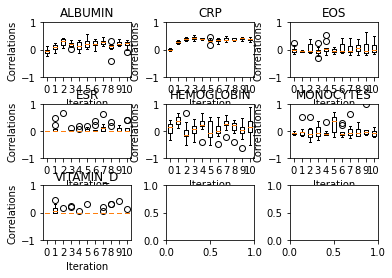

In [101]:
kernel.plot_correlations(wspace=0.4,hspace=0.5)

In [102]:
# Make a multiple imputed dataset with our new data
mice_data_imputed = kernel.impute_new_data(df)
# Return a completed dataset
mice_completed_data = mice_data_imputed.complete_data(0)

## Multivariate feature imputation

In [103]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [104]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df)

IterativeImputer(random_state=0)

In [105]:
new_data = imp.transform(df.to_numpy())
new_data

array([[1.00000000e+00, 6.30000000e+01, 0.00000000e+00, ...,
        1.51244140e+04, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 6.70000000e+01, 0.00000000e+00, ...,
        3.90000000e+01, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 3.30000000e+01, 0.00000000e+00, ...,
        3.52857143e+01, 1.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 6.00000000e+01, 0.00000000e+00, ...,
        3.10000000e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.60000000e+01, 0.00000000e+00, ...,
        2.70000000e+01, 5.00000000e-01, 0.00000000e+00],
       [0.00000000e+00, 6.10000000e+01, 0.00000000e+00, ...,
        1.53348344e+04, 0.00000000e+00, 0.00000000e+00]])

## Multivariate feature imputation with BayesianRidge Regression
"Bayesian regression allows a natural mechanism to survive insufficient data or poorly distributed data by formulating linear regression using probability distributors rather than point estimates. The output or response ‘y’ is assumed to drawn from a probability distribution rather than estimated as a single value."
https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm

In [108]:
imputer = IterativeImputer(BayesianRidge())   # Note that max_iter for IterativeImputer is 10 by default
impute_data_br = pd.DataFrame(imputer.fit_transform(df))
impute_data_br.columns = df.columns

In [109]:
impute_data_br.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,63.0,0.0,0.0,0.0,1.0,1.0,3.566667,1.179918e+06,0.533333,24102.513708,13.225000,2.116667,15124.414006,1.0,1.0
1,1.0,67.0,0.0,0.0,0.0,1.0,0.0,2.575000,7.500000e-01,0.650000,21.000000,10.388889,4.300000,39.000000,1.0,1.0
2,0.0,33.0,0.0,59.0,13.0,2.0,3.0,4.200000,1.821400e+00,0.806818,14.900000,14.171429,3.325758,35.285714,1.0,1.0
3,0.0,45.0,0.0,1.0,2.0,3.0,6.0,3.530000,2.410000e+00,8.956250,2.400000,13.012000,21.078947,8.000000,1.0,1.0
4,0.0,66.0,0.0,0.0,0.0,3.0,4.0,2.705556,3.000000e-01,2.340000,10.000000,12.604545,7.684615,15334.831663,1.0,1.0


## Multivariate feature imputation with RandomForest

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
imputer = IterativeImputer(RandomForestRegressor())  # Note that max_iter for IterativeImputer is 10 by default
impute_data = pd.DataFrame(imputer.fit_transform(df))
impute_data.columns = df.columns

/Users/dbabichenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [111]:
impute_data.head()

,GENDER,AGE,OUTPATIENT,PHONE,VISIT,HOSPITALIZATION,ER,ALBUMIN,CRP,EOS,ESR,HEMOGLOBIN,MONOCYTES,VITAMIN_D,MARITAL_STATUS_ENC,EMPLOYMENT_STATUS_ENC
0,1.0,63.0,0.0,0.0,0.0,1.0,1.0,3.566667,61117.696031,0.533333,28.875484,13.225000,2.116667,32.359494,1.0,1.0
1,1.0,67.0,0.0,0.0,0.0,1.0,0.0,2.575000,0.750000,0.650000,21.000000,10.388889,4.300000,39.000000,1.0,1.0
2,0.0,33.0,0.0,59.0,13.0,2.0,3.0,4.200000,1.821400,0.806818,14.900000,14.171429,3.325758,35.285714,1.0,1.0
3,0.0,45.0,0.0,1.0,2.0,3.0,6.0,3.530000,2.410000,8.956250,2.400000,13.012000,21.078947,8.000000,1.0,1.0
4,0.0,66.0,0.0,0.0,0.0,3.0,4.0,2.705556,0.300000,2.340000,10.000000,12.604545,7.684615,29.813717,1.0,1.0
